# Set up imports

In [19]:
import os
if not os.path.exists("./notebooks"):
    %cd ..

import numpy as np
from src.data_processing import load_mean_std

import torch
from torchvision import transforms
import src.model
from src.training import monte_carlo_predictions, model_validate


# 0. Set Device 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Define Monte Carlo Dropout testing

In [3]:
def monte_carlo_dropout(model, test_loader, samples = 20):
    predictions = []
    for _ in range(samples):
        predictions.append(monte_carlo_predictions(model, test_loader))
        
    predictions = np.stack(predictions , 0)
    mean_predictions = np.mean(predictions, axis=0)
    entropy = -1.0  * np.sum(mean_predictions * np.log(mean_predictions + 1e-16), axis=-1)
    return predictions, entropy

## 2. Define Model Loading

In [4]:
def load_model(model, name) :
    model_path = f"./models/{name}.pth"
    model.load_state_dict(torch.load(model_path, weights_only=True,map_location=torch.device('cpu')))
    model.device = device
    model.to(device)

# 3. Load Models


In [18]:
from src.dataset import prepare_dataset_loaders
from src.config import DATASET_DIR 
mean, std = load_mean_std(f"{DATASET_DIR}/scaling_params.json")

dropout_model = src.model.DropoutCNN() 
load_model(dropout_model, "DropoutCNN")

#model_names = ["OriginalSizeCNN-UNIFORM-RELU", "OriginalSizeCNN-HE-RELU", "OriginalSizeCNN-XAVIER-RELU"]
ensemble_models = []

for i in range(10):
    sample_model = src.model.OriginalSizeCNN()
    model_name = f"OriginalSizeCNN_{i}"
    load_model(sample_model, model_name)
    ensemble_models.append(sample_model)

#ensemble_model = src.model.EnsembleCNN(ensemble_models, 2)
#load_model(ensemble_model, "EnsembleCNN")

10


## 4. Calculate Entropy for models

In [20]:
batch_size = 10 # TODO make it not value from keyboard.


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_loader, val_loader, test_loader = prepare_dataset_loaders(transform, batch_size)


dropout_predictions, dropout_entropy = monte_carlo_dropout(dropout_model, test_loader, samples=10)
dropout_mean_predictions = np.mean(dropout_predictions, axis=0)
dropout_variance_predictions = np.var(dropout_predictions, axis=0)

ensemble_predictions = []
for model in ensemble_models:
    preds, _ = model_validate(model, test_loader)
    ensemble_predictions.append(preds)


print("Dropout Mean Predictions:", dropout_mean_predictions)
print("Dropout Uncertainty Predictions:", dropout_mean_predictions)
print("Entropy for Dropout model:", dropout_entropy)
#print("Entropy for Ensemble model:", ensemble_entropy)
#print("Ensemble Mean Predictions:", ensemble_mean_predictions)




Dropout Mean Predictions: [1.  1.  1.  ... 1.  0.6 1. ]
Dropout Uncertainty Predictions: [1.  1.  1.  ... 1.  0.6 1. ]
Entropy for Dropout model: 694.5659452243785


## Print Statistics 

10x10 Comparison Matrix (Pearson Correlation):
[[0.74557668 0.78266327 0.74737823 0.75666353 0.78653937 0.78862919
  0.73478255 0.78115433 0.77445563 0.77485414]
 [0.74487612 0.78090183 0.75085298 0.76015809 0.78665469 0.78691553
  0.73712902 0.77713868 0.77345382 0.7760812 ]
 [0.74223891 0.77962431 0.75075468 0.7529171  0.78608081 0.79106459
  0.72841033 0.77363162 0.77289236 0.77144347]
 [0.73922815 0.77574321 0.73828899 0.75552503 0.78328823 0.78418205
  0.72984032 0.77424887 0.76714368 0.7679366 ]
 [0.73973919 0.78017809 0.74317316 0.75368236 0.78654759 0.78993215
  0.73061161 0.77609115 0.77004476 0.77198848]
 [0.74197701 0.78293628 0.74850514 0.76014672 0.78822343 0.78908754
  0.74268617 0.77696704 0.77467431 0.77809958]
 [0.74039905 0.77644136 0.74988284 0.75513455 0.78211247 0.78740546
  0.7346931  0.77532782 0.77339041 0.77570724]
 [0.73707673 0.78075223 0.74706846 0.75114108 0.7808528  0.7854493
  0.73374661 0.77178965 0.77546612 0.77070303]
 [0.74297205 0.78570529 0.75307235

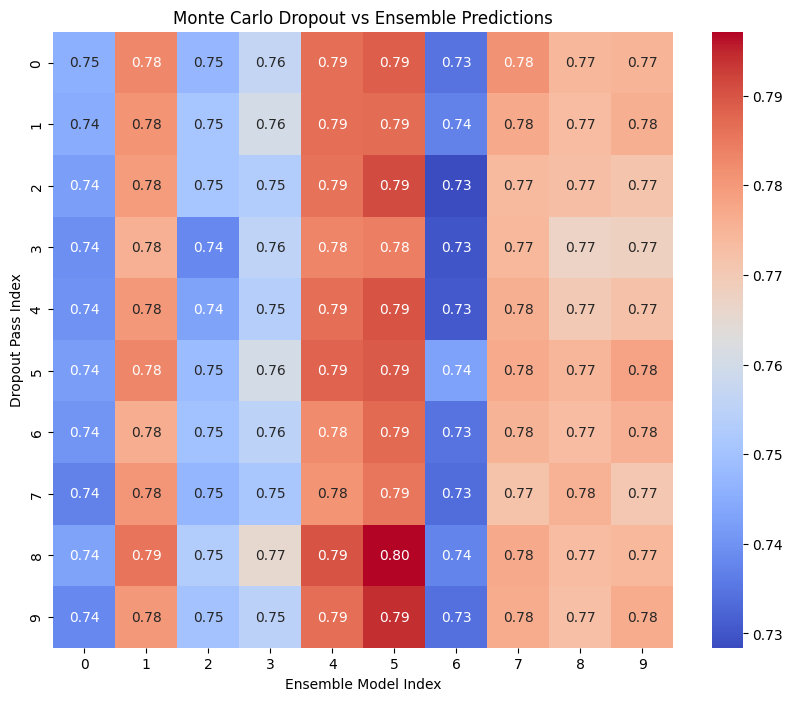

In [23]:
from scipy.stats import pearsonr



from scipy.stats import pearsonr
import numpy as np

# Assuming you already have:
# - `dropout_predictions`: Shape (10, num_samples, num_classes)
# - `ensemble_predictions`: List of length 10 with each element shape (num_samples, num_classes)

# Step 1: Flatten predictions for comparison
dropout_flattened = [pred.flatten() for pred in dropout_predictions]  # Each dropout pass flattened
ensemble_flattened = [np.array(pred).flatten() for pred in ensemble_predictions]  # Each ensemble model flattened

# Step 2: Initialize a 10x10 matrix
comparison_matrix = np.zeros((10, 10))

# Step 3: Compute Pearson correlation for each pair
for i in range(10):  # Iterate over Monte Carlo Dropout predictions
    for j in range(10):  # Iterate over Ensemble model predictions
        correlation, _ = pearsonr(dropout_flattened[i], ensemble_flattened[j])
        comparison_matrix[i, j] = correlation  # Store the correlation

# Step 4: Print or visualize the matrix
print("10x10 Comparison Matrix (Pearson Correlation):")
print(comparison_matrix)

# Optional: Visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(comparison_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Monte Carlo Dropout vs Ensemble Predictions")
plt.xlabel("Ensemble Model Index")
plt.ylabel("Dropout Pass Index")
plt.show()



# Plot Monte Carlo Dropout

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


# Predicted Probabilities
plt.figure(figsize=(10, 5))
sns.histplot(dropout_mean_predictions, bins=30, kde=True, color='blue')
plt.title("Distribution of Predicted Probabilities for Dropout Model")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")

plt.figure(figsize=(10, 5))
sns.histplot(dropout_variance_predictions, bins=30, kde=True, color='blue')
plt.title("Distribution of Variances for Dropout Model")
plt.xlabel("Variance")
plt.ylabel("Frequency")



ModuleNotFoundError: No module named 'seaborn'

In [42]:
# Compute pairwise variance for MC Dropout runs
from sklearn.preprocessing import MinMaxScaler

mc_dropout_variances = np.var(dropout_predictions, axis=0)

# Compute pairwise variance for ensemble models
ensemble_predictions_array = np.stack(ensemble_predictions, axis=0)  # Shape: (10, num_samples, num_classes)
ensemble_variances = np.var(ensemble_predictions_array, axis=0)

print("Average Variance (MC Dropout):", np.mean(mc_dropout_variances))
print("Average Variance (Ensemble):", np.mean(ensemble_variances))

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine predictions for visualization
# Combine individual predictions for visualization
all_predictions = np.vstack([
    dropout_predictions.reshape(-1, dropout_predictions.shape[-1]),  # All MC Dropout predictions
    np.vstack(ensemble_predictions)  # All Ensemble predictions
])

scaler = MinMaxScaler()
all_predictions_normalized = scaler.fit_transform(all_predictions)

# Apply t-SNE
embedded = TSNE(n_components=2, perplexity=min(30, all_predictions_normalized.shape[0] - 1)).fit_transform(all_predictions_normalized)



# Plot
plt.scatter(embedded[:10, 0], embedded[:10, 1], label="MC Dropout", color="blue")
plt.scatter(embedded[10:, 0], embedded[10:, 1], label="Ensemble", color="red")
plt.legend()
plt.title("Loss Landscape (t-SNE Projection)")
plt.show()



Average Variance (MC Dropout): 0.035
Average Variance (Ensemble): 0.040149868247694336


NameError: name 'MinMaxScaler' is not defined

In [26]:
def calculate_entropy(predictions):
    return -np.sum(predictions * np.log(predictions + 1e-8), axis=-1)

# Calculate entropy for MC Dropout
mc_dropout_entropies = calculate_entropy(np.mean(dropout_predictions, axis=0))

# Calculate entropy for Ensemble
ensemble_entropies = calculate_entropy(np.mean(ensemble_predictions_array, axis=0))

print("Average Entropy (MC Dropout):", np.mean(mc_dropout_entropies))
print("Average Entropy (Ensemble):", np.mean(ensemble_entropies))


Average Entropy (MC Dropout): 694.5658871843798
Average Entropy (Ensemble): 771.3735545842111
